# Housing Prices Prediction

This is my notebook on housing prices prediction, using the Ames, Iowa dataset hosted on Kaggle. It's a great way to apply regression techniques and learn how to deal with feature selection and engineering, since the number of features in this dataset is rather large. The objective is to predict the sale price of a house based on the characteristics of the house: size, number of rooms, where it is located, etc.

I'm going to take a very structured approach to this data science problem. It's a very rich dataset that throws up a lot of questions about how to deal with it appropriately.

Going through the typical data science/machine learning workflow, we'll do the following:

- **Exploratory data analysis**: First, we need to understand what we are working with. EDA gives us an initial look at the data and its characteristics before diving into modelling. A few points that popped into my head right away when inspecting the dataset:
    - How to go about the EDA in a dataset with so many features? Should we ignore certain features in the beginning, and come back to them later?
    - Start with correlation between the sale price and other features? Pick only the most correlated ones?
- **Data Processing**: As always, the raw dataset is not quite ready to be used in a machine learning model, so we'll have to go through it, encode categorical features and fill in missing values. Regarding data processing, I had the following questions in mind right from the beginning:
    - How to go about processing all these different features? There are both numeric and categorical features, with some categorical features that are definitely ordinal, while others aren't. 
- **Feature Engineering**: With the large number of features in this dataset, the possibilities for further feature engineering are extensive.
    - There are so many possibilities for feature engineering, it will take some time to figure out which ones are useful and which ones aren't. This is also dependent of the model selection process, since e.g. for linear regression the features have to be engineered, while a feed-forward neural net would be able to figure out important interactions by itself.
- **Model Selection and Cross Validation**: This is the fun part, where we will build various models, tune their hyperparameters, and select the best performing model to make predictions
    - The competition uses an evaluation based on the RMSE between the log of predicted and actual price. I haven't worked with this metric before and at this point I'm not sure how to use it directly in sklearn workflows.
    - Which models should we train? It would be fun to explore a bunch of different regression models, my top picks being different tree-based models (RFs, boosted trees), linear regression, neural nets, and support vector regressors
    - We need to be careful to avoid overfitting this dataset.
- **Making Predictions**: Finally, we can make predictions to submit in the housing prices competition on Kaggle.

Let's get started!

# Exploratory Data Analysis

In [1]:
# load libraries
import math
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import matplotlib
import matplotlib.pyplot as plt
# inline magic
%matplotlib inline
import seaborn as sns; sns.set()
# some stats functions
from scipy import stats
from scipy.stats import norm, skew

training_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

training_data.head(n=10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,Gas

In [2]:
training_data.shape

(1460, 81)

There are a lot of features in this dataset: 81. It might be easiest to just pick out the ones that seem most important in the beginning, and ignore the rest until a later stage. Some features can be grouped as they are relevant only to a specific part of the house.

In [3]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
training_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


It seems that there are very few - if any - **true** missing values. Based on the description of the features in the metadata file, NA mostly indicates that the house does not have the relevant feature, rather missing in the data collection.

Start by exploring some of the features in groups, and focus on visual EDA for now:

**General Features**

- MSSubClass
- MSZoning
- LotArea
- LotFrontage
- Street
- Alley
- LotShape
- LandContour
- LotConfig
- LandSlope
- Neighborhood
- Condition1
- Condition2
- BldgType
- HouseStyle
- OverallQual
- OverallCond
- YearBuilt
- YearRemodAdd
- Foundation
- Functional
- MoSold
- YrSold
- SalePrice
- SaleType
- SaleCondition

**Room Features**

- FullBath
- HalfBath
- BedroomAbvGr
- KitchenAbvGr
- KitchenQual
- TotRmsAbvGrd

**Basement Features**

- BsmtQual
- BsmtCond
- BsmtExposure
- BsmtFinType1
- BsmtFinSF1
- BsmtFinType2
- BsmtFinSF2
- BsmtUnfSF
- TotalBsmtSF
- BsmtFullBath
- BsmtHalfBath

**Garage Features**

- GarageType
- GarageYrBlt
- GarageFinish
- GarageCars
- GarageArea
- GarageQual
- GarageCond

**Exterior and Roof Features**

- RoofStyle
- RoofMatl
- Exterior1st
- Exterior2nd
- MasVnrType
- MasVnrArea
- ExterQual
- ExterCond
- PavedDrive
- Fence

**Luxury features**

- Fireplaces
- FireplaceQu

**Porch/Patio/Pool**

- WoodDeckSF
- OpenPorchSF
- EnclosedPorch
- 3SsnPorch
- ScreenPorch
- PoolArea
- PoolQC
- MiscFeature
- MiscVal

**Utilities**

- Utilities
- Heating
- HeatingQC
- CentralAir
- Electrical

# Response Variable; Sale Price

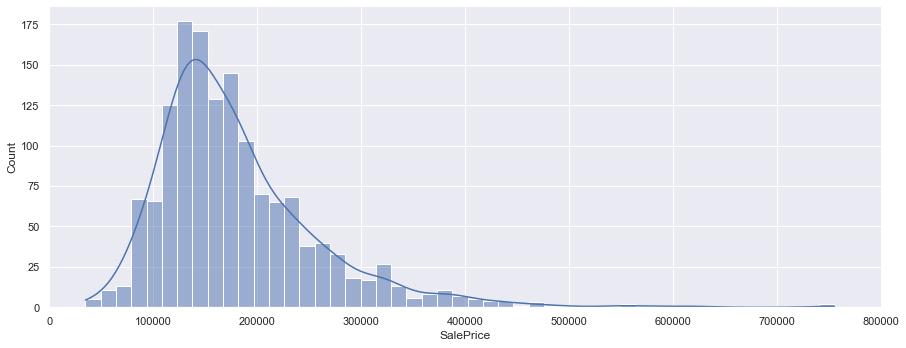

In [5]:
sns.displot(data=training_data, x='SalePrice', kde=True, aspect=2.5);
plt.xlim([0,800000]);

Distribution of the sale prices seems reasonable. Has a heavier tail towards higher prices, with a few houses beyond 500000 that could be considered to be outliers

# Correlation of numeric predictors with sale price

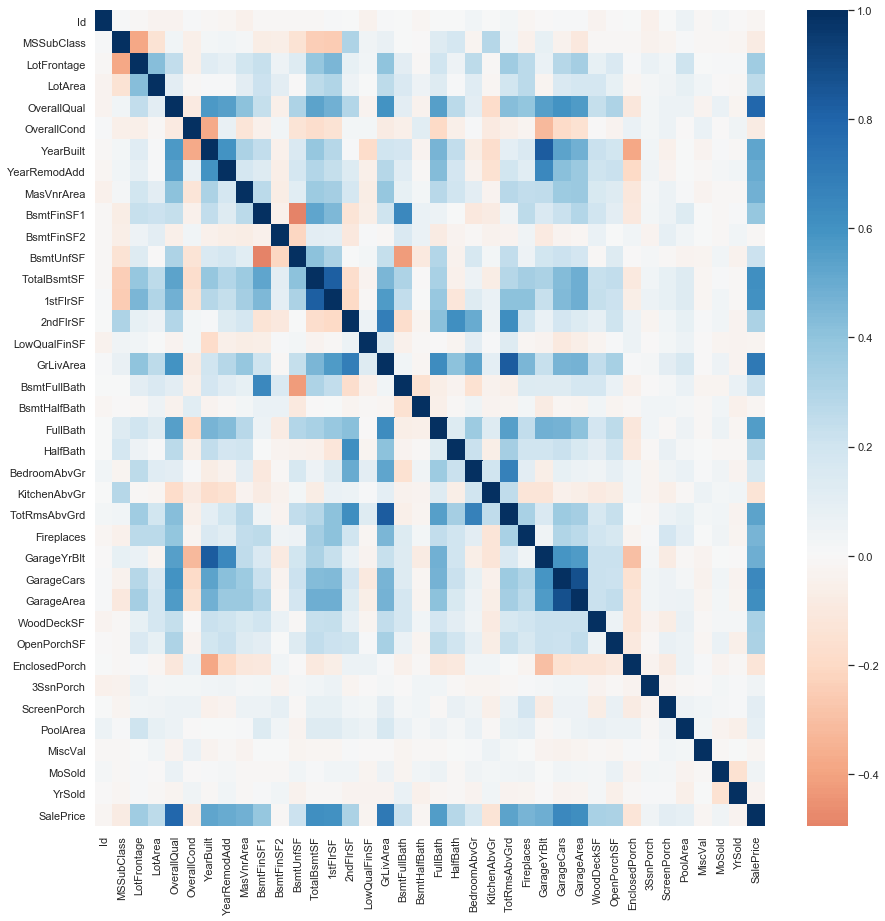

In [6]:
fig, ax = plt.subplots(figsize=[15.0,15.0])
sns.heatmap(training_data.corr(), cmap='RdBu', center=0.0, ax=ax);

In [7]:
training_data.corr()['SalePrice'].sort_values(ascending=False).head(n=10)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

OverallQual, GrLivArea have the highest correlation with SalePrice, which makes sense. A few of the features are clearly dependent, such as GarageCars and GarageArea. TotalBsmtSF (square footage of basement) and 1stFlrSF (square footage of 1st floor) are also strongly correlated: this makes sense since both should be roughly equal to the footprint of the house.

# General features

- MSSubClass
- MSZoning
- LotArea
- LotFrontage
- Street
- Alley
- LotShape
- LandContour
- LotConfig
- LandSlope
- Neighborhood
- Condition1
- Condition2
- BldgType
- HouseStyle
- OverallQual
- OverallCond
- YearBuilt
- YearRemodAdd
- Foundation
- Functional
- MoSold
- YrSold
- SalePrice
- SaleType
- SaleCondition

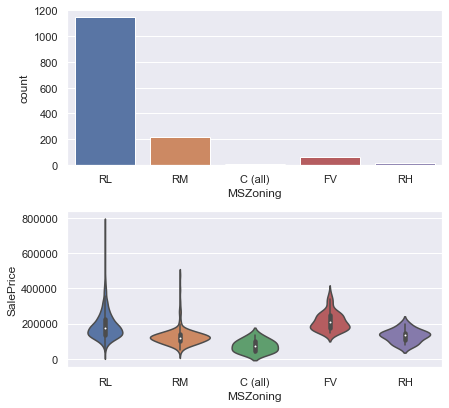

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1, figsize=[6.4, 5.8])
sns.countplot(data=training_data, x='MSZoning', ax=ax1)
sns.violinplot(data=training_data, x='MSZoning', y='SalePrice', ax=ax2); plt.tight_layout()

- Large majority of buildings are in residential areas of low or medium density. Categories C, FV, RH are underrepresented. There seem to be clear differences in price between the different types of areas.

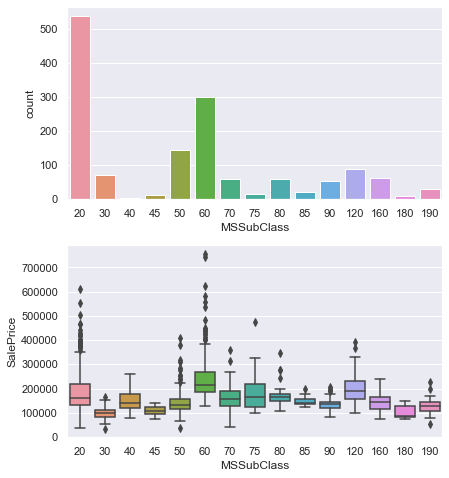

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1, figsize=[6.4, 6.8])
sns.countplot(data=training_data, x='MSSubClass', ax=ax1)
sns.boxplot(data=training_data, x='MSSubClass', y='SalePrice', ax=ax2); plt.tight_layout()

- Not sure how useful this MSSubClass classification is. Based on description, most of it can be inferred from combination of number of levels/stories and building year. Most houses fall into categories 20, 50, 60. Replace MSSubClass with average price of house in that category?
---

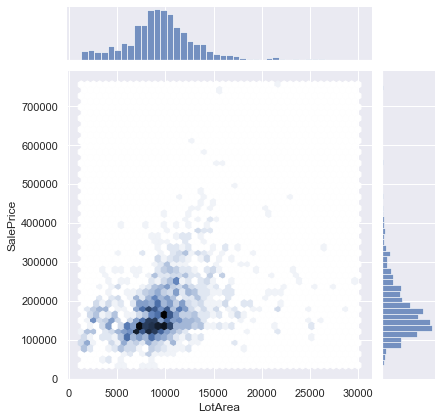

In [10]:
sns.jointplot(data=training_data[training_data['LotArea'] < 30000.0], x='LotArea', y='SalePrice', kind='hex');

In [11]:
print(training_data['LotArea'].describe())

count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64


- Lot area is interesting: Most are below 25000 sqft, and the minimum is 1300sqft. There are a few outliers with massive lot area. The kde of this feature would be close to normal but is cut off at zero of course.
- There is some correlation between the lot area and sale price. I've cut off the lot area at 30000 to make the plot more meaningful.

---

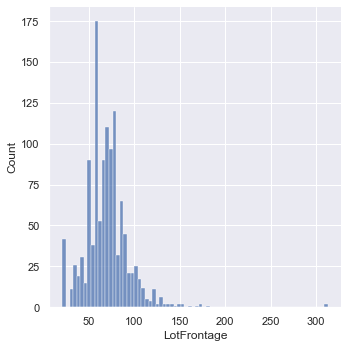

In [12]:
sns.displot(data=training_data, x='LotFrontage');

- Lot frontage is defined as length of street connected to property. It has a number of missing values: how to interpret these? Are those properties not connected to a street? This can't be the case, as the 'Street' feature has no missing values, so there must always be some type of access and therefore lot frontage.
- It might make sense to simply replace these with the median.

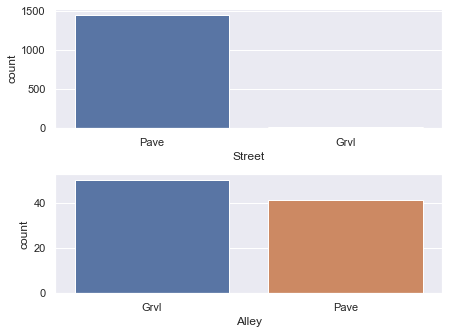

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1, figsize=[6.4, 4.8])
sns.countplot(data=training_data, x='Street', ax=ax1);
sns.countplot(data=training_data, x='Alley', ax=ax2);plt.tight_layout()

- Both of these features could probably be ignored.

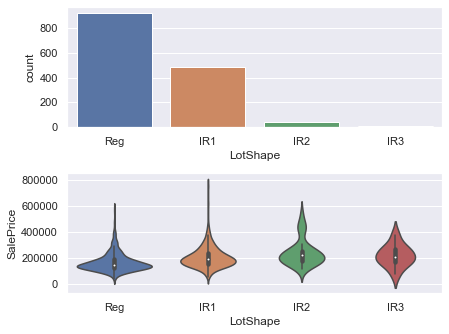

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1, figsize=[6.4, 4.8])
sns.countplot(data=training_data, x='LotShape', ax=ax1);
sns.violinplot(data=training_data, x='LotShape', y='SalePrice', ax=ax2); plt.tight_layout()

- Most lots are shaped regularly, no clear connection between shape and price: could be that there is a different factor that is important. Hints that more irregular lots might be more expensive (maybe larger? upward trending median).

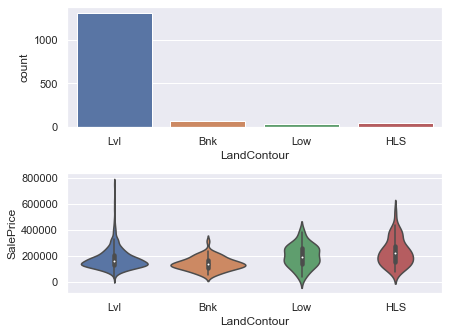

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1, figsize=[6.4, 4.8])
sns.countplot(data=training_data, x='LandContour', ax=ax1);
sns.violinplot(data=training_data, x='LandContour', y='SalePrice', ax=ax2); plt.tight_layout()

- Most land is level. Prices are rather spread, no clear relation to LandContour.

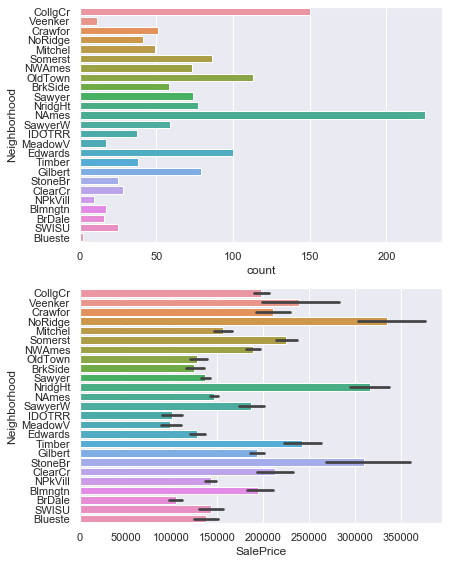

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1, figsize=[6.4, 8.0])
sns.countplot(data=training_data, y='Neighborhood', ax=ax1);
sns.barplot(data=training_data, y='Neighborhood', x='SalePrice', ax=ax2); plt.tight_layout()

- Not sure what to make of this yet - might be useful to group neighborhoods according to average house prices, or drop this feature altogether?

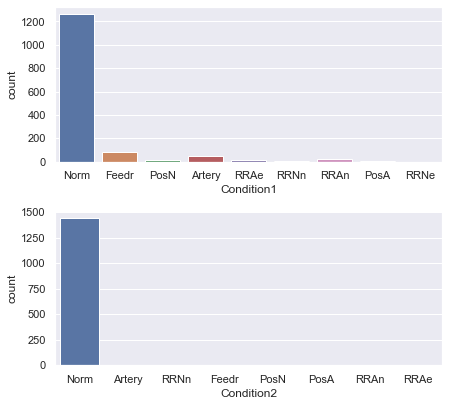

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1, figsize=[6.4, 5.8])
sns.countplot(data=training_data, x='Condition1', ax=ax1);
sns.countplot(data=training_data, x='Condition2', ax=ax2); plt.tight_layout()

- Most houses fall into one class. Might be best to ignore this feature.

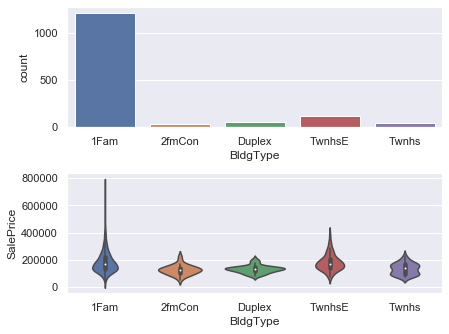

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1, figsize=[6.4, 4.8])
sns.countplot(data=training_data, x='BldgType', ax=ax1);
sns.violinplot(data=training_data, x='BldgType', y='SalePrice', ax=ax2); plt.tight_layout()

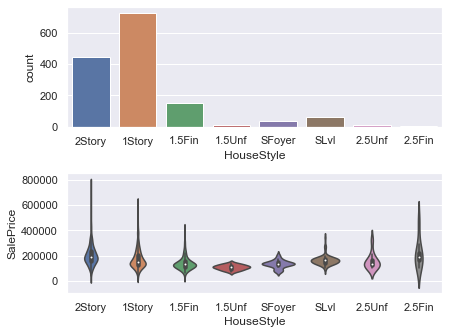

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1, figsize=[6.4, 4.8])
sns.countplot(data=training_data, x='HouseStyle', ax=ax1);
sns.violinplot(data=training_data, x='HouseStyle', y='SalePrice', ax=ax2); plt.tight_layout()

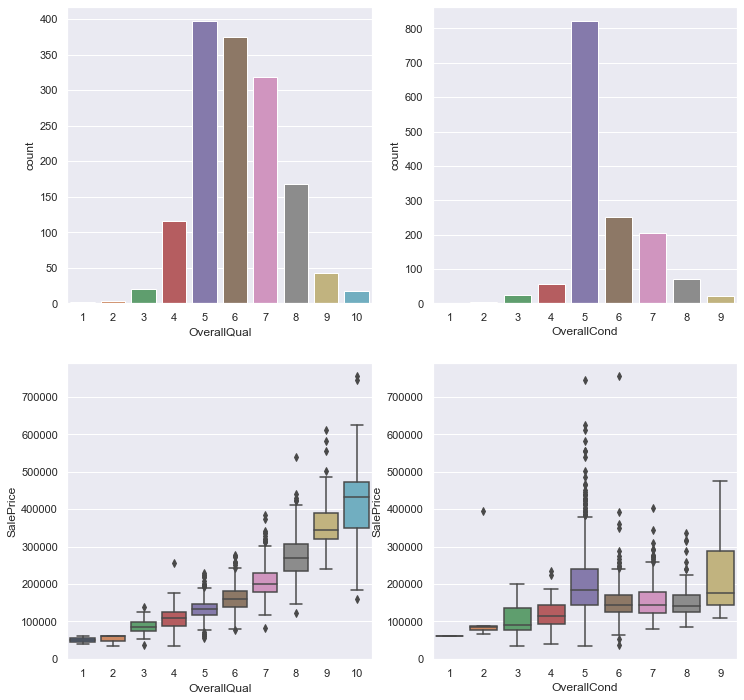

In [20]:
fig, axs = plt.subplots(nrows=2,ncols=2, figsize=[12.0, 12.0])
sns.countplot(data=training_data, x='OverallQual', ax=axs[0][0]);
sns.countplot(data=training_data, x='OverallCond', ax=axs[0][1]);
sns.boxplot(data=training_data, x='OverallQual', y='SalePrice', ax=axs[1][0]);
sns.boxplot(data=training_data, x='OverallCond', y='SalePrice', ax=axs[1][1]);

- Most houses are average, which is to be expected.
- OverallQual is nicely correlated with sale price, and shows a slight upward trend, deviating from linearity.
- OverallCond does not seem to be as useful.

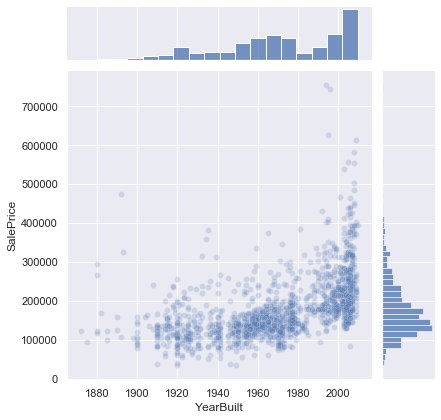

In [21]:
sns.jointplot(data=training_data, x='YearBuilt', y='SalePrice', kind='scatter', alpha=0.2);

- This distribution looks reasonable. There might be a slight correlation between the two variables. Would be useful to turn this into 'age of house' feature. Newer houses more expensive?

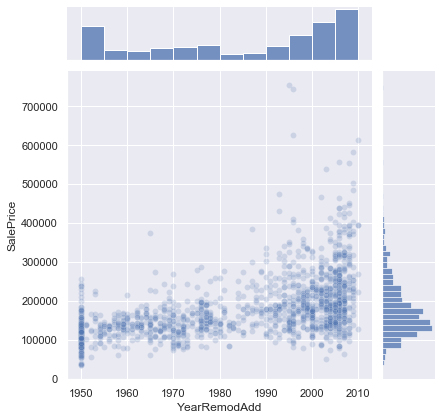

In [22]:
sns.jointplot(data=training_data, x='YearRemodAdd', y='SalePrice', kind='scatter', alpha=0.2);

- Remodelling date might be capped at 1950?
- Turn this feature into binary 'Remodelled? yes/no' feature.

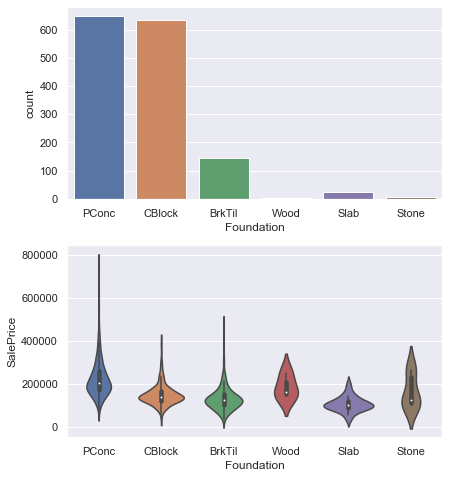

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1, figsize=[6.4, 6.8])
sns.countplot(data=training_data, x='Foundation', ax=ax1);
sns.violinplot(data=training_data, x='Foundation', y='SalePrice', ax=ax2); plt.tight_layout()

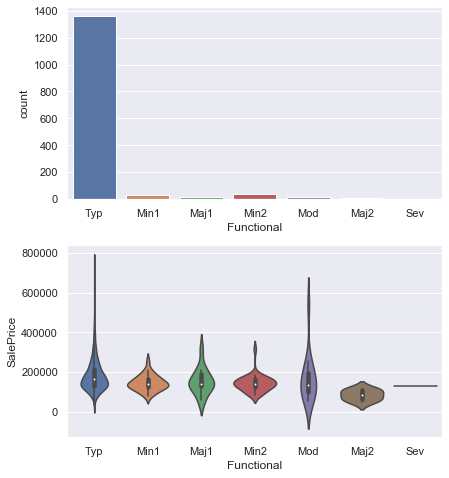

In [24]:
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1, figsize=[6.4, 6.8])
sns.countplot(data=training_data, x='Functional', ax=ax1);
sns.violinplot(data=training_data, x='Functional', y='SalePrice', ax=ax2); plt.tight_layout()

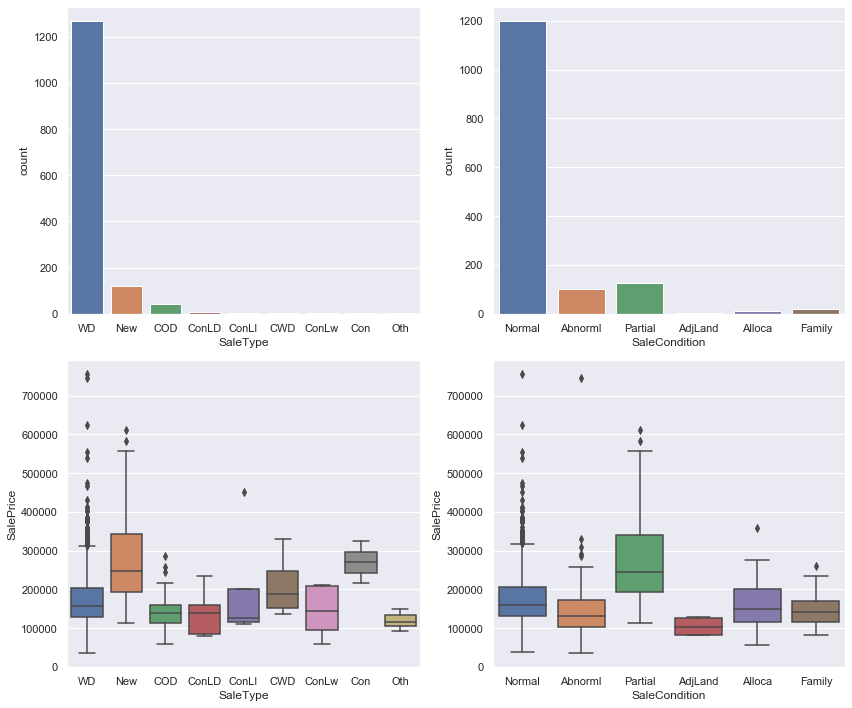

In [25]:
fig, axs = plt.subplots(nrows=2,ncols=2, figsize=[12.0, 10.0])
sns.countplot(data=training_data, x='SaleType', ax=axs[0][0]);
sns.countplot(data=training_data, x='SaleCondition', ax=axs[0][1]);
sns.boxplot(data=training_data, x='SaleType', y='SalePrice', ax=axs[1][0]);
sns.boxplot(data=training_data, x='SaleCondition', y='SalePrice', ax=axs[1][1]); plt.tight_layout()

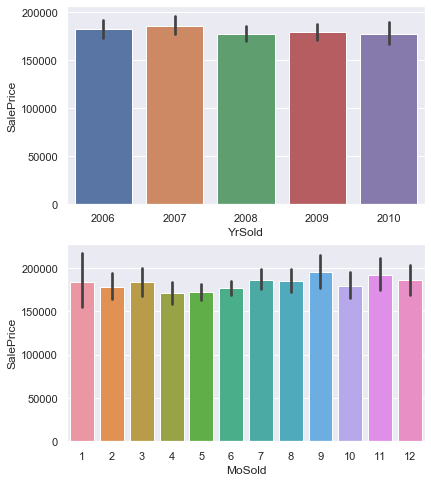

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[6.4, 8.0])
sns.barplot(data=training_data, x='YrSold', y='SalePrice', ax=axs[0]);
sns.barplot(data=training_data, x='MoSold', y='SalePrice', ax=axs[1]);

- One might have expected a clear pattern here because of the 2008 financial crisis but there seems to be only a small effect.

**Some of the general features are already very predictive.**

## Room Features

- FullBath
- HalfBath
- BedroomAbvGr
- KitchenAbvGr
- KitchenQual
- TotRmsAbvGrd

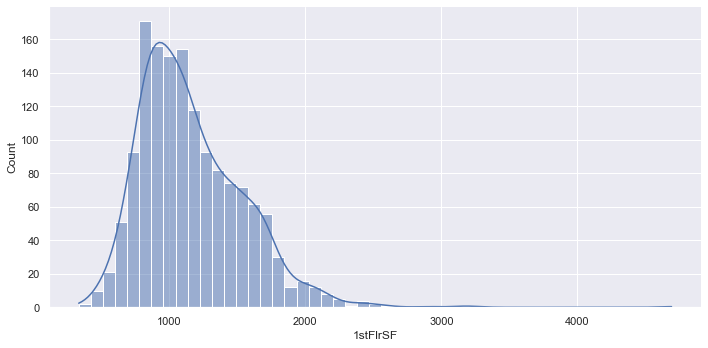

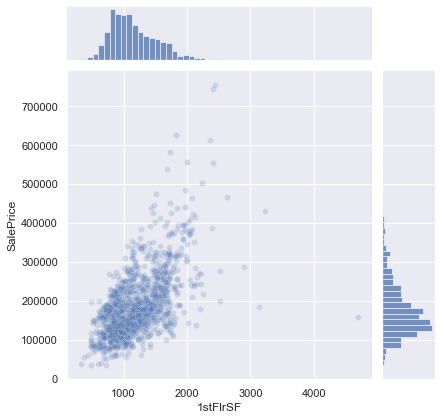

In [27]:
sns.displot(data=training_data, x='1stFlrSF', kde=True, aspect=2); plt.show()
sns.jointplot(data=training_data, x='1stFlrSF', y='SalePrice', kind='scatter', alpha=0.2);

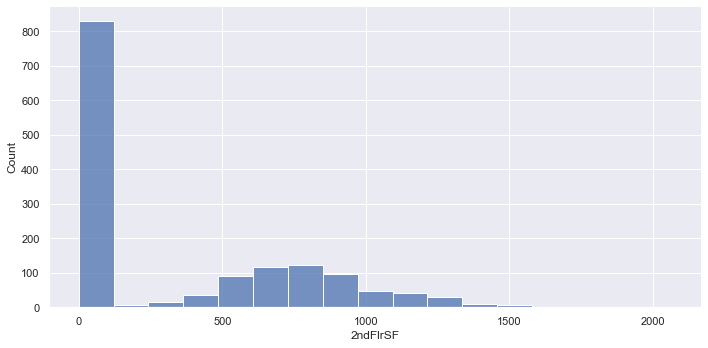

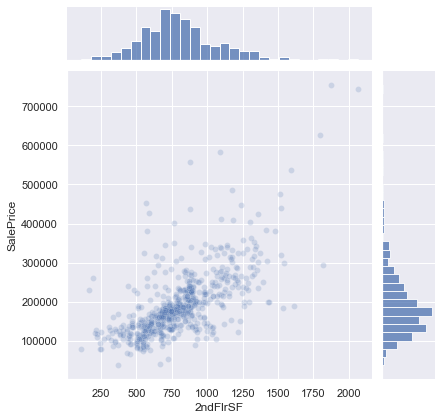

In [28]:
sns.displot(data=training_data, x='2ndFlrSF', aspect=2); plt.show()
sns.jointplot(data=training_data[training_data['2ndFlrSF'] > 0], x='2ndFlrSF', y='SalePrice', kind='scatter', alpha=0.2);

- These distributions also make sense - zero 2nd floor sf means there is no 2nd floor. Might be useful to introduce an indicator variable 0/1 for presence of 2nd floor?
- Reasonable degree of correlation between size of floors and price.

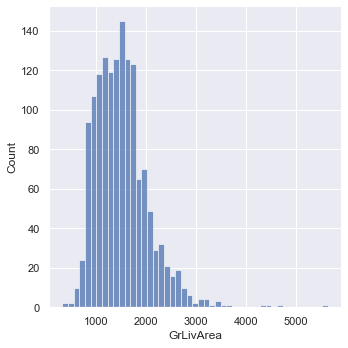

In [29]:
sns.displot(data=training_data, x='GrLivArea'); plt.show()

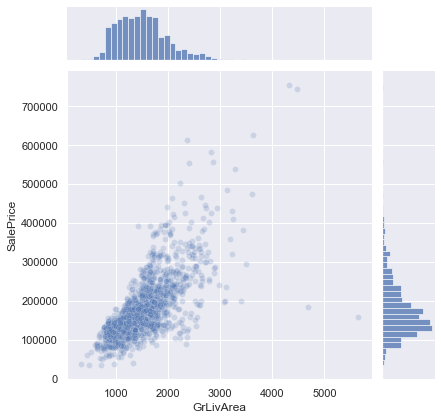

In [30]:
sns.jointplot(data=training_data, x='GrLivArea', y='SalePrice', kind='scatter', alpha=0.2);

- From the correlation analysis we found that GrLivArea is the feature with the 2nd highest correlation with sale price.

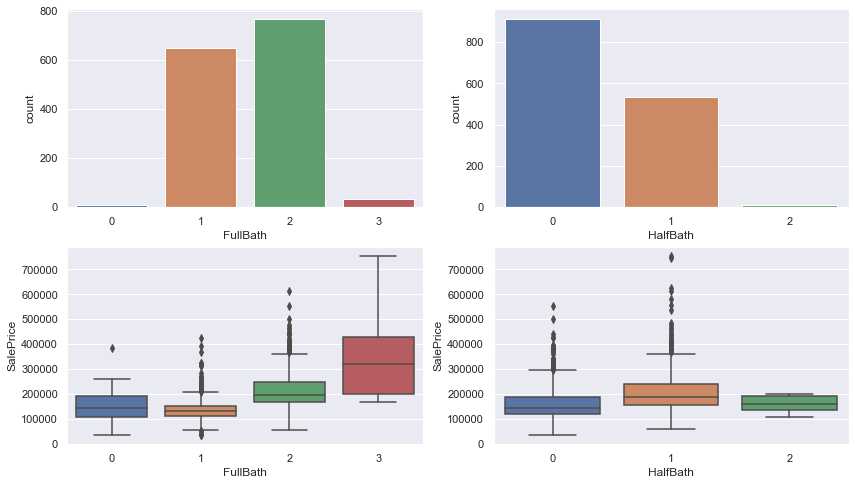

In [31]:
fig, axs = plt.subplots(nrows=2,ncols=2, figsize=[14.0, 8.0])
sns.countplot(data=training_data, x='FullBath', ax=axs[0][0]);
sns.boxplot(data=training_data, x='FullBath', y='SalePrice', ax=axs[1][0]);
sns.countplot(data=training_data, x='HalfBath', ax=axs[0][1])
sns.boxplot(data=training_data, x='HalfBath', y='SalePrice', ax=axs[1][1]);

- Bigger house, more bathrooms means higher sale price. Makes sense. There is also a feature for the bathrooms in the basement which I will explore later.

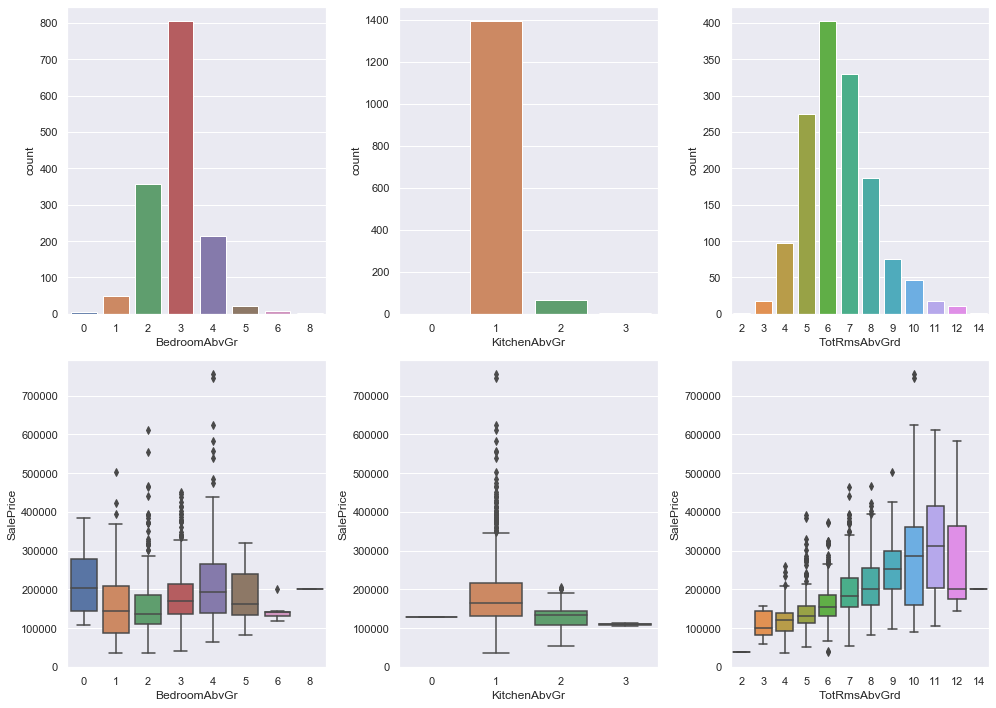

In [32]:
fig, axs = plt.subplots(nrows=2,ncols=3, figsize=[14.0, 10.0])
sns.countplot(data=training_data, x='BedroomAbvGr', ax=axs[0][0]);
sns.boxplot(data=training_data, x='BedroomAbvGr', y='SalePrice', ax=axs[1][0]);
sns.countplot(data=training_data, x='KitchenAbvGr', ax=axs[0][1]);
sns.boxplot(data=training_data, x='KitchenAbvGr', y='SalePrice', ax=axs[1][1]);
sns.countplot(data=training_data, x='TotRmsAbvGrd', ax=axs[0][2]);
sns.boxplot(data=training_data, x='TotRmsAbvGrd', y='SalePrice', ax=axs[1][2]); plt.tight_layout()

- Most houses have 3 bedrooms, 1 kitchen, 6 rooms in total

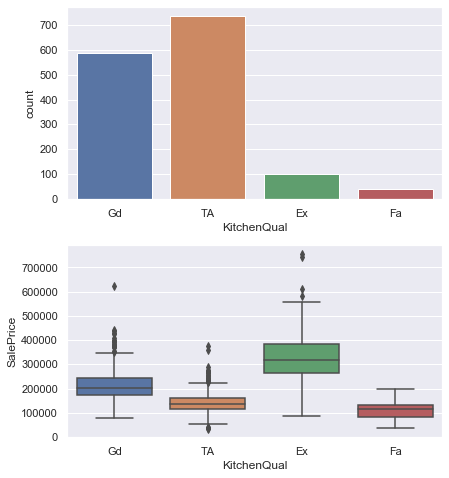

In [33]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=[6.4, 6.8])
sns.countplot(data=training_data, x='KitchenQual', ax=ax1);
sns.boxplot(data=training_data, x='KitchenQual', y='SalePrice', ax=ax2); plt.tight_layout()

- All of these features should  be useful.

## Basement Features

- BsmtQual
- BsmtCond
- BsmtExposure
- BsmtFinType1
- BsmtFinSF1
- BsmtFinType2
- BsmtFinSF2
- BsmtUnfSF
- TotalBsmtSF
- BsmtFullBath
- BsmtHalfBath

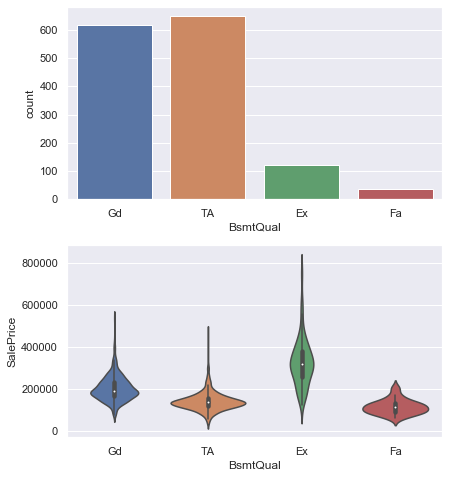

In [34]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[6.4, 6.8])
sns.countplot(data=training_data, x='BsmtQual', ax=axs[0]);
sns.violinplot(data=training_data, x='BsmtQual', y='SalePrice', ax=axs[1]); plt.tight_layout()

- BsmtQual captures the basement height. Houses with higher basements are more expensive.

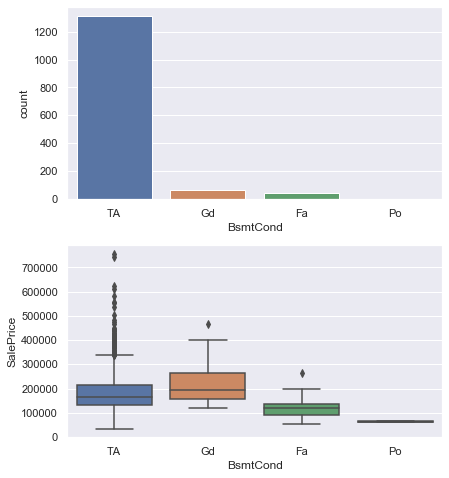

In [35]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[6.4, 6.8])
sns.countplot(data=training_data, x='BsmtCond', ax=axs[0]);
sns.boxplot(data=training_data, x='BsmtCond', y='SalePrice', ax=axs[1]); plt.tight_layout()

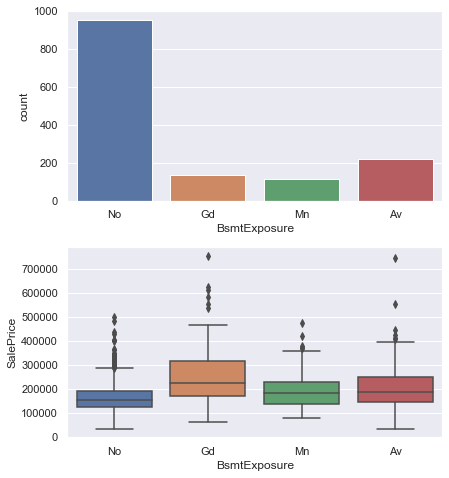

In [36]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[6.4, 6.8])
sns.countplot(data=training_data, x='BsmtExposure', ax=axs[0]);
sns.boxplot(data=training_data, x='BsmtExposure', y='SalePrice', ax=axs[1]); plt.tight_layout()

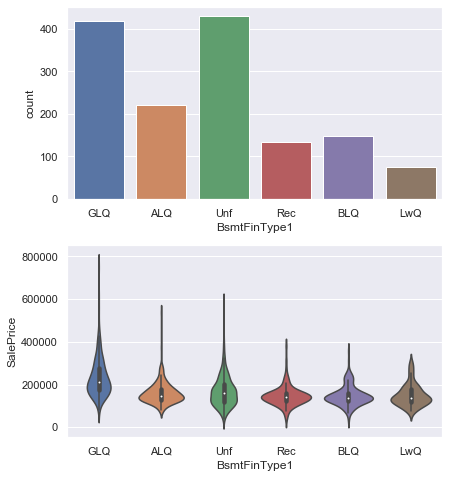

In [37]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[6.4, 6.8])
sns.countplot(data=training_data, x='BsmtFinType1', ax=axs[0]);
sns.violinplot(data=training_data, x='BsmtFinType1', y='SalePrice', ax=axs[1]); plt.tight_layout()

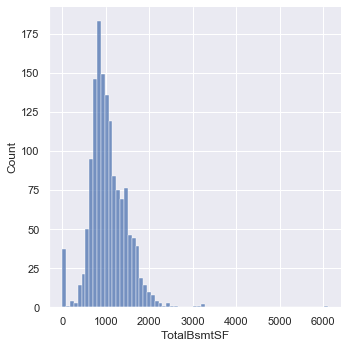

In [38]:
sns.displot(data=training_data, x='TotalBsmtSF');

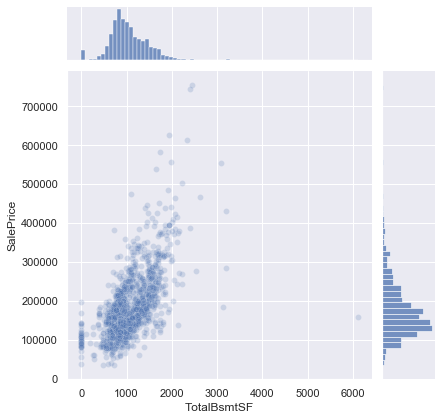

In [39]:
sns.jointplot(data=training_data, x='TotalBsmtSF', y='SalePrice', kind='scatter', alpha=0.2);

- Square footage of basement is reasonably well-correlated with sale price. Interpret 0 sq footage as no basement present.

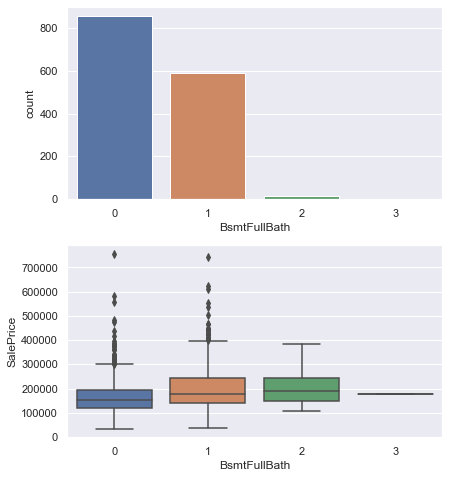

In [40]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[6.4, 6.8])
sns.countplot(data=training_data, x='BsmtFullBath', ax=axs[0]);
sns.boxplot(data=training_data, x='BsmtFullBath', y='SalePrice', ax=axs[1]); plt.tight_layout()

It seems excessive to include this many features for the basement in a model. However, it might be useful to keep them and select and a later stage.

## Garage Features

- GarageType
- GarageYrBlt
- GarageFinish
- GarageCars
- GarageArea
- GarageQual
- GarageCond

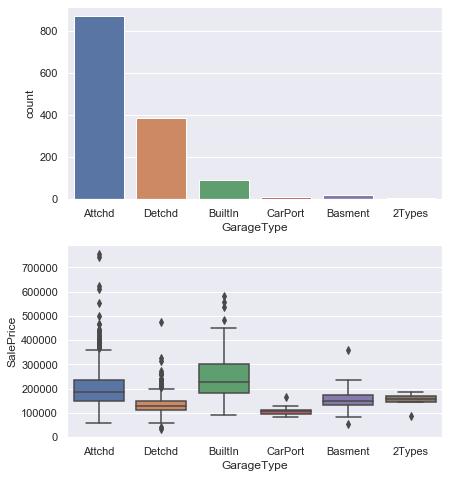

In [41]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[6.4, 6.8])
sns.countplot(data=training_data, x='GarageType', ax=axs[0]);
sns.boxplot(data=training_data, x='GarageType', y='SalePrice', ax=axs[1]); plt.tight_layout()

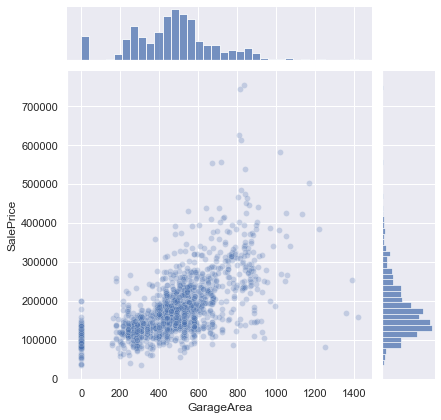

In [42]:
sns.jointplot(data=training_data, x='GarageArea', y='SalePrice', alpha=0.25);

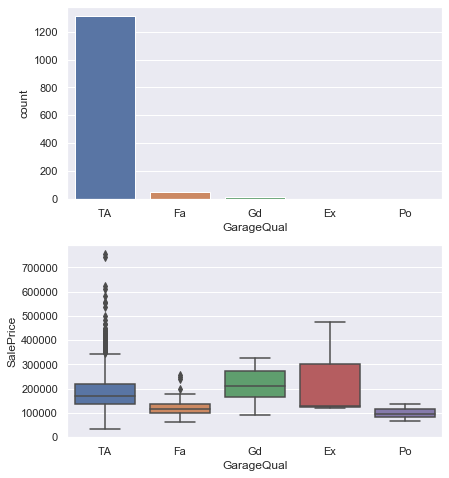

In [43]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[6.4, 6.8])
sns.countplot(data=training_data, x='GarageQual', ax=axs[0]);
sns.boxplot(data=training_data, x='GarageQual', y='SalePrice', ax=axs[1]); plt.tight_layout()

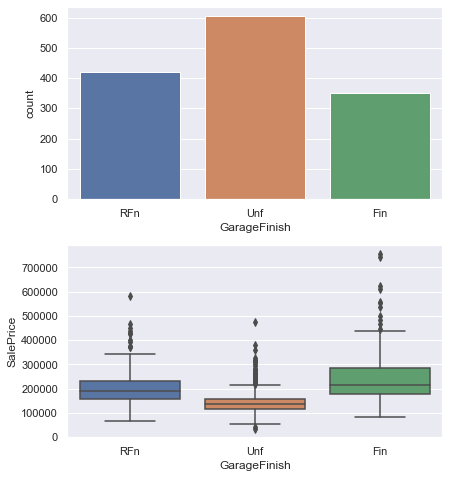

In [44]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[6.4, 6.8])
sns.countplot(data=training_data, x='GarageFinish', ax=axs[0]);
sns.boxplot(data=training_data, x='GarageFinish', y='SalePrice', ax=axs[1]); plt.tight_layout()

- It looks like out of all the different garage features GarageArea and GarageType are most important.

## Exterior and Roof Features

- RoofStyle
- RoofMatl
- Exterior1st
- Exterior2nd
- MasVnrType
- MasVnrArea
- ExterQual
- ExterCond
- PavedDrive
- Fence

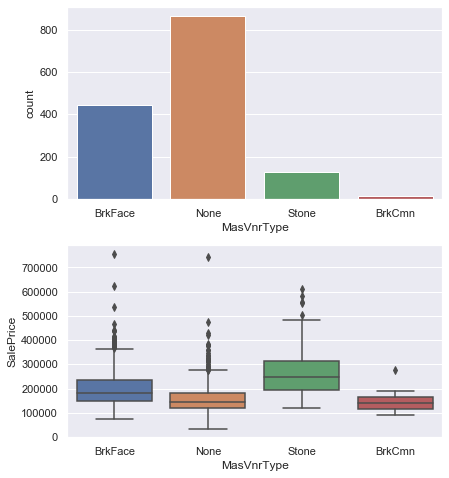

In [45]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[6.4, 6.8])
sns.countplot(data=training_data, x='MasVnrType', ax=axs[0]);
sns.boxplot(data=training_data, x='MasVnrType', y='SalePrice', ax=axs[1]); plt.tight_layout()

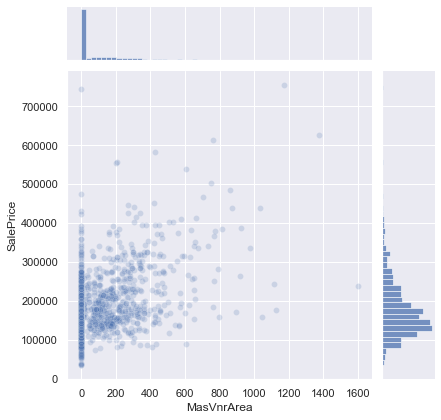

In [46]:
sns.jointplot(data=training_data, x='MasVnrArea', y='SalePrice', kind='scatter', alpha=0.2);

Not keeping all plots in the notebook, ExterQual and Fence seem to be the most useful.

## Luxury Features

- Fireplaces
- FireplaceQu

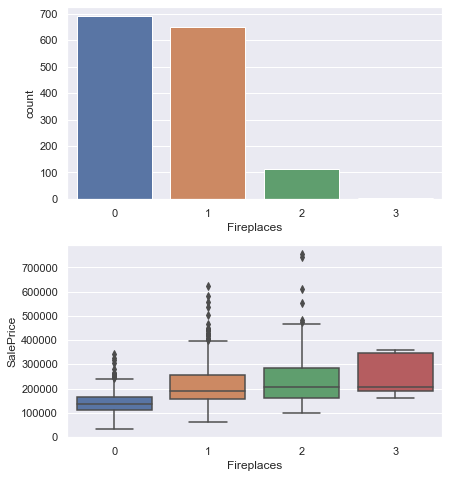

In [47]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[6.4, 6.8]);
sns.countplot(data=training_data, x='Fireplaces', ax=axs[0]);
sns.boxplot(data=training_data, x='Fireplaces', y='SalePrice', ax=axs[1]); plt.tight_layout()

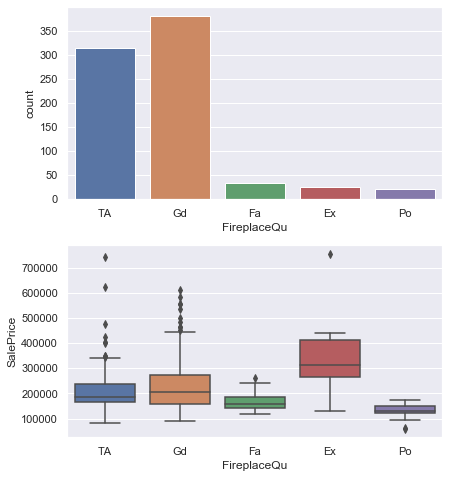

In [48]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[6.4, 6.8]);
sns.countplot(data=training_data, x='FireplaceQu', ax=axs[0]);
sns.boxplot(data=training_data, x='FireplaceQu', y='SalePrice', ax=axs[1]); plt.tight_layout()

- Both features should be useful. Also introduce HasFireplace feature.

## Porch/Patio/Pool/Extras

- WoodDeckSF
- OpenPorchSF
- EnclosedPorch
- 3SsnPorch
- ScreenPorch
- PoolArea
- PoolQC
- MiscFeature
- MiscVal

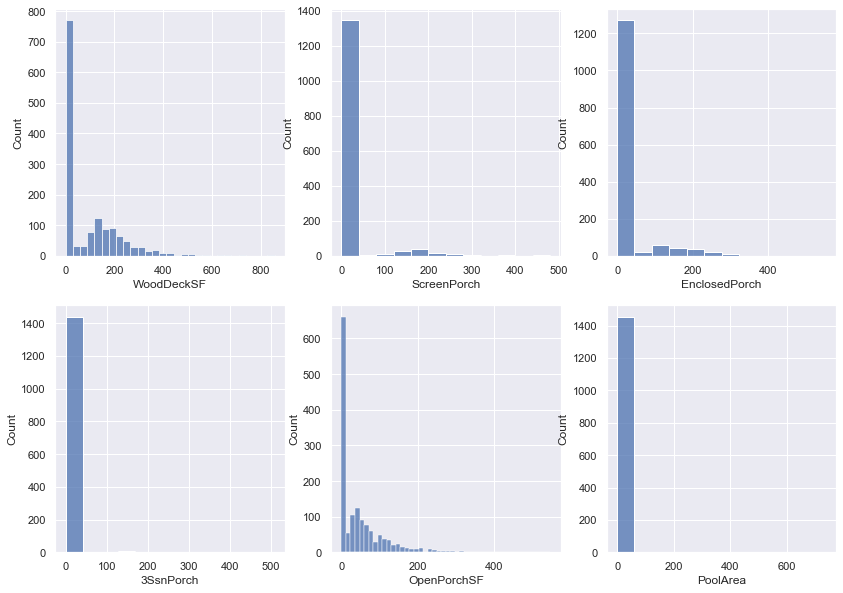

In [49]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=[14.0, 10.0])
outside_feats = ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']
for i, j, feat in zip(list(range(2))*3, list(range(3))*2, outside_feats):
    sns.histplot(data=training_data, x=feat, ax=axs[i][j]);

- Lots of house without special features like porch/pool. Should consolidate porch features into one.

## Utilities

- Utilities
- Heating
- HeatingQC
- CentralAir
- Electrical

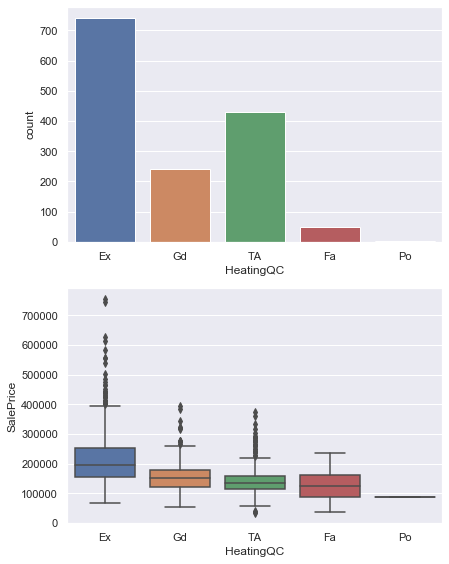

In [50]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[6.4, 8.0])
sns.countplot(data=training_data, x='HeatingQC', ax=axs[0]);
sns.boxplot(data=training_data, x='HeatingQC', y='SalePrice', ax=axs[1]); plt.tight_layout()

To save space I'm not keeping plots of all of these features in the notebook. It looks like HeatingQC and CentralAir are the two most useful.

## Feature Engineering and Data Processing

For an initial attempt, I had only used the features listed below. Model performance can still be improved though by keeping more features. I'll keep track of what makes the biggest difference throughout the next few section.

In [51]:
general_features = ['MSSubClass', 'LotArea', 'LotFrontage', 'Neighborhood', 'BldgType', 'HouseStyle', 'OverallQual', 'YearBuilt', 'YrSold', 'YearRemodAdd', 'Foundation']
rooms_features = ['1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'KitchenQual']
basement_features = ['TotalBsmtSF', 'BsmtFinType1', 'BsmtHalfBath', 'BsmtFullBath']
garage_features = ['GarageType', 'GarageArea']
fireplace_features = ['Fireplaces', 'FireplaceQu']
outside_features = ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']
target = ['SalePrice']

all_features = general_features + rooms_features + basement_features + garage_features + fireplace_features + outside_features

There are a few features that could be useful if added, although they are already represented to a large part in the existing features: total living space, age of house, age of remodelling, is the house new, full number of baths.

In [52]:
def add_features(df):
    """ Features that might be useful based on EDA. """
    df['HouseAge'] = df['YrSold'] - df['YearBuilt']
    df['RemodelAge'] = df['YrSold'] - df['YearRemodAdd']
    df['TotAreaSq'] = df['GrLivArea'] + df['TotalBsmtSF']
    df['TotBath'] = df['FullBath'] + 0.5*df['HalfBath'] + df['BsmtFullBath'] + 0.5*df['BsmtHalfBath']
    df['TotPorch'] = df['WoodDeckSF'] + df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
    df['IsNew'] = df['HouseAge'].apply(lambda x: 1 if x == 0 else 0)
    # indicator variables for various features of the house
    df['Has2ndFlr'] = df['2ndFlrSF'].apply(lambda x: 1 if x != 0.0 else 0)
    df['HasBsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x != 0.0 else 0)
    df['HasGarage'] = df['GarageArea'].apply(lambda x: 1 if x != 0.0 else 0)
    df['GarageAge'] = df['YrSold'] - df['GarageYrBlt']
    df['HasFireplace'] = df['Fireplaces'].apply(lambda x: 1 if x != 0.0 else 0)
    df['HasPorch'] = df['TotPorch'].apply(lambda x: 1 if x != 0.0 else 0)
    df['HasMasonry'] = df['MasVnrArea'].apply(lambda x: 1 if x != 0.0 else 0)
    df['MoSold'] = df['MoSold'].astype('str')
    df['YrSold'] = df['YrSold'].astype('str')
    df['MSSubClass'] = df['MSSubClass'].astype('str')
    return df

Replacing the MSSubClass and Neighborhood categories by the average house prices.

In [53]:
neighborhood_prices = training_data.groupby('Neighborhood')['SalePrice'].agg('median')
mssubclass_prices = training_data.groupby('MSSubClass')['SalePrice'].agg('median')

def groupby_avg(df, neighborhood_prices=neighborhood_prices, mssubclass_prices=mssubclass_prices):
    # need this to handle missing/unknown values
    neighborhoods = neighborhood_prices.keys()
    mssubclasses = mssubclass_prices.keys()
    # fill with median for category
    df['NeighborhoodMedianPrice'] = df['Neighborhood'].apply(lambda x: neighborhood_prices[x]\
                                                          if x in neighborhood_prices.keys()\
                                                             else np.mean(neighborhood_prices.values))
    df['MSSubClassMedianPrice'] = df['MSSubClass'].apply(lambda x: mssubclass_prices[x]\
                                                        if x in mssubclass_prices.keys()\
                                                         else np.mean(mssubclass_prices.values))
    return df

In [54]:
drop_feats = ['Id']

def drop_features(df, features):
    return df.drop(features, axis=1)

In [55]:
# add and pre-select features for the training data
def preproc_data(data):
    df = data.copy()
    df = add_features(df)
    df = groupby_avg(df)
    df = drop_features(df, drop_feats)
    return df

In [56]:
#df_train.head()

Let's have another look at the correlation between features and sale price.

In [57]:
#fig, ax = plt.subplots(figsize=[12.0,12.0])
#sns.heatmap(df_train.corr(), cmap='RdBu', center=0.0, ax=ax);

In [58]:
#df_train.corr()['SalePrice'].sort_values(ascending=False).head(n=20)

## Drop Outliers

Here we remove two outliers from the training data: houses with very large square footage that sell for low prices.

In [59]:
def train_remove_outliers(df):
    return df_train[df_train['TotAreaSq'] < 7500]

In [60]:
# add features
df_train = preproc_data(training_data)
df_test = preproc_data(test_data)
# remove outliers
df_train = train_remove_outliers(df_train)

### Skewness

In [61]:
num_feats = df_train.dtypes[df_train.dtypes != "object"].index

In [62]:
skewness = df_train[num_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_feats = skewness[abs(skewness) > 0.75].index

In [63]:
skewed_feats = skewed_feats.drop('SalePrice')

In [64]:
from scipy.special import boxcox1p
def fix_skewness(df, skewed_feats, lam=0.15):
    for feat in skewed_feats:
        df[feat] = boxcox1p(df[feat], lam)
    return df

In [65]:
skewness

MiscVal                    24.434913
PoolArea                   15.932532
LotArea                    12.560986
3SsnPorch                  10.286510
LowQualFinSF                8.995688
IsNew                       4.534373
KitchenAbvGr                4.480268
BsmtFinSF2                  4.247550
ScreenPorch                 4.114690
BsmtHalfBath                4.095895
EnclosedPorch               3.083987
MasVnrArea                  2.685003
OpenPorchSF                 2.337421
SalePrice                   1.879360
WoodDeckSF                  1.544214
LotFrontage                 1.541112
TotPorch                    1.103269
NeighborhoodMedianPrice     1.015230
GrLivArea                   1.009951
BsmtUnfSF                   0.919955
1stFlrSF                    0.886723
TotAreaSq                   0.816240
2ndFlrSF                    0.812121
BsmtFinSF1                  0.764002
OverallCond                 0.690324
HalfBath                    0.679351
TotRmsAbvGrd                0.659822
G

---

In [66]:
# fix skewness
df_train = fix_skewness(df_train, skewed_feats)
df_test = fix_skewness(df_test, skewed_feats)

## Preliminary Model Exploration with Random Forests

In [68]:
df_train.loc[:,df_train.dtypes != 'object'].head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,HouseAge,RemodelAge,TotAreaSq,TotBath,TotPorch,IsNew,Has2ndFlr,HasBsmt,HasGarage,GarageAge,HasFireplace,HasPorch,HasMasonry,NeighborhoodMedianPrice,MSSubClassMedianPrice
0,5.831328,19.212182,7,5,2003,2003,8.059126,11.170327,0.0,7.483296,856,11.692623,11.686189,0.0,13.698888,1,0.000000,2,1,3,0.730463,8,0,2003.0,2,548,0.000000,5.714669,0.000000,0.0,0.0,0.0,0.0,208500,5,5,14.976591,3.5,5.714669,0.0,1,0.730463,0.730463,5.0,0,0.730463,1,34.842604,144922.0
1,6.221214,19.712205,6,8,1976,1976,0.000000,12.062832,0.0,8.897844,1262,12.792276,0.000000,0.0,12.792276,0,0.730463,2,0,3,0.730463,6,1,1976.0,2,460,9.010206,0.000000,0.000000,0.0,0.0,0.0,0.0,181500,31,31,14.923100,2.5,9.010206,0.0,0,0.730463,0.730463,31.0,1,0.730463,0,35.471682,144922.0
2,5.914940,20.347241,7,5,2001,2002,7.646538,10.200343,0.0,9.917060,920,11.892039,11.724598,0.0,13.832085,1,0.000000,2,1,3,0.730463,6,1,2001.0,2,608,0.000000,5.053371,0.000000,0.0,0.0,0.0,0.0,223500,7,6,15.149678,3.5,5.053371,0.0,1,0.730463,0.730463,7.0,1,0.730463,1,34.842604,144922.0
3,5.684507,19.691553,7,5,1915,1970,0.000000,8.274266,0.0,10.468500,756,12.013683,11.354094,0.0,13.711364,1,0.000000,1,0,3,0.730463,7,1,1998.0,3,642,0.000000,4.745132,8.797736,0.0,0.0,0.0,0.0,140000,91,36,14.857121,2.0,9.080098,0.0,1,0.730463,0.730463,8.0,1,0.730463,0,34.949924,144922.0
4,6.314735,21.325160,8,5,2000,2000,9.391827,10.971129,0.0,10.221051,1145,12.510588,12.271365,0.0,14.480029,1,0.000000,2,1,4,0.730463,9,1,2000.0,3,836,8.013884,6.314735,0.000000,0.0,0.0,0.0,0.0,250000,8,8,15.852312,3.5,8.831514,0.0,1,0.730463,0.730463,8.0,1,0.730463,1,37.572003,144922.0


I just want to get a quick look at model performance and feature importance before building a full processing pipeline. Extracting feature importance from a multi-step sklearn pipeline is a little fiddly so I'd like to get some insight at this point.

In [69]:
# import ML models
from sklearn.ensemble import RandomForestRegressor
# import model validation functionality
from sklearn.model_selection import cross_val_score

X = df_train.loc[:,df_train.dtypes != 'object'].drop('SalePrice', axis=1).fillna(0.0)
y = np.log(df_train['SalePrice'])

rf_model = RandomForestRegressor()

cross_val_score(rf_model, X, y, scoring='neg_root_mean_squared_error', cv=5)

array([-0.12994238, -0.13534074, -0.14225154, -0.13171376, -0.14224306])

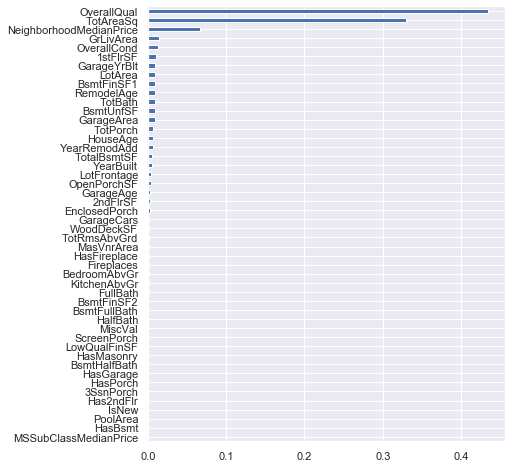

In [70]:
rf_model.fit(X, y)
rf_model.feature_importances_

feat_import = pd.Series(rf_model.feature_importances_)
feat_import.index = X.columns
fig, ax = plt.subplots(figsize=[6.4, 8.0])
feat_import.sort_values().plot(kind='barh', ax=ax);

The most important feature depends on the preprocessing but: It looks like the total area is by far the most important feature, followed closely by OverallQual. The median price for houses in the same neighborhood is the third most important feature. This makes sense given the correlation values we've observed previously.

## Data Preprocessing

Let's check missing again for missing values:

In [71]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1459
Data columns (total 95 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MSSubClass               1458 non-null   object 
 1   MSZoning                 1458 non-null   object 
 2   LotFrontage              1199 non-null   float64
 3   LotArea                  1458 non-null   float64
 4   Street                   1458 non-null   object 
 5   Alley                    91 non-null     object 
 6   LotShape                 1458 non-null   object 
 7   LandContour              1458 non-null   object 
 8   Utilities                1458 non-null   object 
 9   LotConfig                1458 non-null   object 
 10  LandSlope                1458 non-null   object 
 11  Neighborhood             1458 non-null   object 
 12  Condition1               1458 non-null   object 
 13  Condition2               1458 non-null   object 
 14  BldgType                

Based on the information in the data description file and the EDA, it looks like almost all null values indicate **absence of the feature from the house** rather than a value that wasn't collected. An appropriate imputation strategy is therefore to fill the missing values with either zero (numeric) or an indication that the house doesn't have the feature ('None').

In [72]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# imputers for num and cat features
cat_imp = SimpleImputer(strategy='constant', fill_value='None')
num_imp = SimpleImputer(strategy='constant', fill_value=0.0)

# onehot encoding for cat features
OH_enc = OneHotEncoder(drop=None, sparse=False, handle_unknown='ignore')
cat_transformer = Pipeline(steps=[('cat_imp', cat_imp), ('onehot', OH_enc)])

# imputation and scaling for numerical features
scaler = RobustScaler()
num_transformer = Pipeline(steps=[('num_imp', num_imp), ('scale', scaler)])

# list num and cat features
cat_features = df_train.columns[df_train.dtypes == 'object']
num_features = [f for f in df_train.columns[df_train.dtypes != 'object'] if f !='SalePrice']

# full preprocessor
preproc = ColumnTransformer(transformers=[('cat', cat_transformer, cat_features), ('num', num_transformer, num_features)])

In [73]:
df_preproc = pd.DataFrame(preproc.fit_transform(df_train)) # verify that preprocessor works as expected

In [74]:
df_preproc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.050317,-0.264327,0.5,0.0,0.663043,0.243243,1.050805,0.140043,0.0,-0.838055,-0.269192,-0.511696,1.038541,0.0,0.352028,1.0,0.000000,0.0,1.0,0.0,0.0,1.0,-1.0,0.604651,0.0,0.280164,0.000000,0.261217,0.000000,0.0,0.0,0.0,0.0,-0.652174,-0.243243,0.088996,3.0,-0.549240,0.0,1.0,0.0,0.0,-0.463415,-1.0,0.0,1.0,0.247541,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.391171,0.030550,0.

## Model Selection and Validation

An important point to keep in mind during model selection and validation is that for the kaggle competition, we're trying to minimize the root-mean-squared-error between log of sale price and prediction. This could be done in two different ways: (1) take the log of the sale price and use that for `y_train`, then convert predictions back to normal scale at the end, or (2) use a custom scorer function in sklearn that minimises the correct loss. I'll go with the first option for now.

In [100]:
# import ML models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.svm import SVR, LinearSVR
# import model validation functionality
from sklearn.model_selection import cross_val_score, GridSearchCV

# training set
X_train = preproc.fit_transform(df_train.drop(['SalePrice'], axis=1))
y_train = np.log(df_train['SalePrice'])

# test set
X_test = preproc.transform(df_test)

### Feature selection and baseline performance

In [101]:
lasso_model = Lasso()
param_grid = {'alpha':[0.0001*n for n in range(1,21)],
             'max_iter':[10000]}

gs_cv = GridSearchCV(lasso_model, param_grid, scoring='neg_root_mean_squared_error', cv=5, refit=True)
gs_cv.fit(X_train, y_train)

print(X_train.shape)

best_model = gs_cv.best_estimator_
parameters = gs_cv.best_params_
print('Best hyperparameters: {}'.format(parameters))
print('Best score: {}'.format(gs_cv.best_score_))
feat_sel = best_model.coef_ != 0

X_train = X_train[:,feat_sel]
X_test = X_test[:, feat_sel]

print('Lasso has selected {} features and dropped {} features.'.format(sum(feat_sel), len(best_model.coef_) - sum(feat_sel)))

(1458, 346)
Best hyperparameters: {'alpha': 0.0006000000000000001, 'max_iter': 10000}
Best score: -0.10935985107889334
Lasso has selected 103 features and dropped 243 features.


In [102]:
models = [RandomForestRegressor(), XGBRegressor(), KNeighborsRegressor(), Lasso(), Ridge(), ElasticNet(), SVR(), LinearSVR()]
model_names = ['RF', 'XGB', 'KNN', 'Lasso', 'Ridge', 'ElasticNet', 'SVR', 'LinearSVR']

# test baseline model performance
for model, name in zip(models, model_names):
    #pipe_model = Pipeline(steps=[('preprocessing', preproc), ('ML_model', model)])
    cv_scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
    print('CV score for {}: {}'.format(name, np.mean(cv_scores)))

CV score for RF: -0.13256340075141662
CV score for XGB: -0.12629516827348314
CV score for KNN: -0.1781867008943095
CV score for Lasso: -0.3863871215395937
CV score for Ridge: -0.10690626325099997
CV score for ElasticNet: -0.3777264000046371
CV score for SVR: -0.12571353454139675


/Users/cankocer/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/cankocer/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/cankocer/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/cankocer/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CV score for LinearSVR: -0.11712941142549586


/Users/cankocer/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Tree based models

In [ ]:
# param_grid = {'n_estimators':[50,100,200,250],
#              #'ML_model__max_depth':[15,20,25],
#              'max_features':['auto', 'sqrt']}

# # optimised parameters for future reference
# #opt_param_grid = 

# gs_cv = GridSearchCV(RandomForestRegressor(), param_grid, scoring='neg_root_mean_squared_error', cv=5, refit=True)
# gs_cv.fit(X_train, y_train)

# best_model = gs_cv.best_estimator_
# parameters = gs_cv.best_params_
# print('Best hyperparameters: {}'.format(parameters))
# print('Best score: {}'.format(gs_cv.best_score_))

In [103]:
param_grid = {'learning_rate':[0.05],
            'n_estimators':[500],
             'max_depth':[4],
             'min_child_weight':[2, 3, 4]}

# optimised parameters for future reference
opt_param_grid = {'learning_rate': [0.05], 'max_depth': [4], 'min_child_weight': [2], 'n_estimators': [500]}

gs_cv = GridSearchCV(XGBRegressor(), opt_param_grid, scoring='neg_root_mean_squared_error', cv=5, refit=True)
gs_cv.fit(X_train, y_train)

best_model = gs_cv.best_estimator_
parameters = gs_cv.best_params_
print('Best hyperparameters: {}'.format(parameters))
print('Best score: {}'.format(gs_cv.best_score_))

y_pred = best_model.predict(X_test)
submission = pd.DataFrame({'Id':test_data['Id'], 'XGB':y_pred})
submission.head()

Best hyperparameters: {'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 500}
Best score: -0.11421829412038567


,Id,XGB
0,1461,11.738647
1,1462,12.007166
2,1463,12.153000
3,1464,12.153486
4,1465,12.175794


---

### Linear models

In [104]:
lasso_model = Lasso()
param_grid = {'alpha':[0.0001*n for n in range(1,21)],
             'max_iter':[10000]}

gs_cv = GridSearchCV(lasso_model, param_grid, scoring='neg_root_mean_squared_error', cv=5, refit=True)
gs_cv.fit(X_train, y_train)

best_model = gs_cv.best_estimator_
parameters = gs_cv.best_params_
print('Best hyperparameters: {}'.format(parameters))
print('Best score: {}'.format(gs_cv.best_score_))

y_pred = best_model.predict(X_test)
submission['Lasso'] = y_pred
submission.head()

Best hyperparameters: {'alpha': 0.0002, 'max_iter': 10000}
Best score: -0.10669717800062743


,Id,XGB,Lasso
0,1461,11.738647,11.695848
1,1462,12.007166,11.964564
2,1463,12.153000,12.125911
3,1464,12.153486,12.217139
4,1465,12.175794,12.201254


In [105]:
ridge_model = Ridge()
param_grid = {'alpha':[1.0*n for n in range(1,21)],
             'max_iter':[10000]}

gs_cv = GridSearchCV(ridge_model, param_grid, scoring='neg_root_mean_squared_error', cv=5, refit=True)
gs_cv.fit(X_train, y_train)

best_model = gs_cv.best_estimator_
parameters = gs_cv.best_params_
print('Best hyperparameters: {}'.format(parameters))
print('Best score: {}'.format(gs_cv.best_score_))

y_pred = best_model.predict(X_test)
submission['Ridge'] = y_pred
submission.head()

Best hyperparameters: {'alpha': 4.0, 'max_iter': 10000}
Best score: -0.10664056095103384


,Id,XGB,Lasso,Ridge
0,1461,11.738647,11.695848,11.694571
1,1462,12.007166,11.964564,11.969849
2,1463,12.153000,12.125911,12.127298
3,1464,12.153486,12.217139,12.217805
4,1465,12.175794,12.201254,12.199781


### Support Vector Regressor

A tuned SVR turns out to have excellent performance, on par with the tree based models. RBF kernel seems to perform best, I didn't have much patience in tuning the parameters for other types of kernels.

In [106]:
#svr_model = Pipeline(steps=[('preprocessing', preproc), ('ML_model', SVR())])
param_grid = {'C':[1.0, 2.0, 3.0, 4.0]},
#             'ML_model__kernel':['rbf'],
#             'ML_model__epsilon':[0.1, 1.0, 10.0]}

# optimised parameter set for future reference
#opt_param_grid = 

gs_cv = GridSearchCV(SVR(), param_grid, scoring='neg_root_mean_squared_error', cv=5, refit=True)
gs_cv.fit(X_train, y_train)

best_model = gs_cv.best_estimator_
parameters = gs_cv.best_params_
print('Best hyperparameters: {}'.format(parameters))
print('Best score: {}'.format(gs_cv.best_score_))

y_pred = best_model.predict(X_test)
submission['SVR'] = y_pred
submission.head()

Best hyperparameters: {'C': 2.0}
Best score: -0.1252761221823504


,Id,XGB,Lasso,Ridge,SVR
0,1461,11.738647,11.695848,11.694571,11.717059
1,1462,12.007166,11.964564,11.969849,12.135851
2,1463,12.153000,12.125911,12.127298,12.140892
3,1464,12.153486,12.217139,12.217805,12.220511
4,1465,12.175794,12.201254,12.199781,12.185661


---

In [107]:
#linsvr_model = Pipeline(steps=[('preprocessing', preproc), ('ML_model', LinearSVR())])
param_grid = {'C':[1.4, 1.5, 1.6, 1.7, 1.8]}

gs_cv = GridSearchCV(LinearSVR(), param_grid, scoring='neg_root_mean_squared_error', cv=5, refit=True)
gs_cv.fit(X_train, y_train)

best_model = gs_cv.best_estimator_
parameters = gs_cv.best_params_
print('Best hyperparameters: {}'.format(parameters))
print('Best score: {}'.format(gs_cv.best_score_))

y_pred = best_model.predict(X_test)
submission['LinSVR'] = y_pred
submission.head()

/Users/cankocer/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/cankocer/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/cankocer/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/cankocer/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/cankocer/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, i

Best hyperparameters: {'C': 1.4}
Best score: -0.1204561573187147


/Users/cankocer/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/cankocer/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,Id,XGB,Lasso,Ridge,SVR,LinSVR
0,1461,11.738647,11.695848,11.694571,11.717059,11.720935
1,1462,12.007166,11.964564,11.969849,12.135851,12.082766
2,1463,12.153000,12.125911,12.127298,12.140892,12.190789
3,1464,12.153486,12.217139,12.217805,12.220511,12.302375
4,1465,12.175794,12.201254,12.199781,12.185661,12.173664


### Final Model Predictions

---

In [108]:
submission = submission[['Id', 'XGB', 'Lasso', 'LinSVR']]

In [109]:
submission.head()

,Id,XGB,Lasso,LinSVR
0,1461,11.738647,11.695848,11.720935
1,1462,12.007166,11.964564,12.082766
2,1463,12.153000,12.125911,12.190789
3,1464,12.153486,12.217139,12.302375
4,1465,12.175794,12.201254,12.173664


In [110]:
submission['SalePrice'] = (submission['XGB'] + 2.0 * submission['Lasso']) / 3.0

In [111]:
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: np.exp(x))

In [112]:
submission.head()

,Id,XGB,Lasso,LinSVR,SalePrice
0,1461,11.738647,11.695848,11.720935,121797.427431
1,1462,12.007166,11.964564,12.082766,159335.020612
2,1463,12.153000,12.125911,12.190789,186267.784578
3,1464,12.153486,12.217139,12.302375,197980.024274
4,1465,12.175794,12.201254,12.173664,197356.528990


In [113]:
submission[['Id', 'SalePrice']].to_csv('submission.csv', index=False)